# Real Data Simulation

@Author: Daniel Rodríguez Delgado

@Date: 02/09/2019

In [1]:
from alpha_vantage.timeseries import TimeSeries
# Here you should use your Alpha Vantage API key
ts=TimeSeries(key='FT8ZMTO1NJSILIKB', output_format='pandas')
import time
import pandas as pd
import numpy as np
from math import *
from scipy.stats import kurtosis, skew, pearsonr, norm, t
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'


## 1. Pseudo-random number generators

In [2]:
def congru(seed, m=((2**31)-1), a=16807, b=0):
        y=(a*seed+b)%m
        u=y/m
        return(u, y)
    
def boxmuller(seed, mu=0, sigma=1):
    u1, seed=congru(seed)    #Uniform inputs
    u2, seed=congru(seed)
    
    x=sqrt(-2*log(u1))*cos(2*pi*u2)*sigma+mu  #Gaussian numbers generation
    y=sqrt(-2*log(u1))*sin(2*pi*u2)*sigma+mu
    
    antx=sqrt(-2*log(1-u1))*cos(2*pi*(1-u2))*sigma+mu  #Antithetic numbers generation
    anty=sqrt(-2*log(1-u1))*sin(2*pi*(1-u2))*sigma+mu
    return(x, y, u1, u2, antx, anty, seed)


def marsaglia(seed, mu=0, sigma=1, mode='normal'):
    
    while True:
        if mode=='normal':
            u1, seed= congru(seed)
            u2, seed= congru(seed)
            v1=2*u1-1
            v2=2*u2-1
            R2=v1**2+v2**2
            if R2<=1:
                y=sqrt(-2*log(R2)/R2)
                x1=v1*y*sigma+mu
                x2=v2*y*sigma+mu
                break
        if mode=='antithetic':
            u1, seed= congru(seed)
            u2, seed= congru(seed)
            v1=2*(1-u1)-1
            v2=2*(1-u2)-1
            R2=v1**2+v2**2
            if R2<=1:
                y=sqrt(-2*log(R2)/R2)
                x1=v1*y*sigma+mu
                x2=v2*y*sigma+mu
                break
        
    return(x1,x2,seed)

# Gamma distribution random generator
def gamma (p, a, seed):
    v=[]
    for i in range(p):
        u, seed= congru(seed)
        v.append(log(u))
    x=-sum(v)/a
    return(x, seed)


# Chi^2 distribution random generator
def chisq (n, seed):
    if (n%2==0):
        g, seed=gamma(int(n/2), 1/2, seed)
        return(g, seed)
    else:
        g, seed=gamma(int((n-1)/2), 1/2, seed)
        cos1, sen1, u1, u2, antx, anty, seed = boxmuller(seed)
        x=g+sen1**2
    return(x, seed)

# t-student distribution random generator
def tstudent (n, seed):
    cos1, sen1, u1, u2, antx, anty, seed=boxmuller(seed)
    xchi, seed=chisq(n, seed)
    x=sen1/sqrt(xchi/n)
    return(x, seed)


## 2. Data load

Following code gather real prices and dividends data by using Alpha Vantage API. Loaded data are the adjusted close prices and they're necessary in order to calculate the variance for each stock.

In [5]:
import time

#abs ,'TSLA','FOX'
tickers=['AAPL','AMZN','ALXN','NFLX','EXPE','PYPL','TSLA','FOX']

companies=pd.DataFrame()
dividends=pd.DataFrame()
data=pd.DataFrame()
meta_data=pd.DataFrame()

for i in range(len(tickers)):
    tick=tickers[i]
    print(tick)
    data, meta_data = ts.get_daily_adjusted(symbol=tick,outputsize='full')
    
    divs=pd.DataFrame(data['7. dividend amount'])
    data=pd.DataFrame(data['5. adjusted close'])            
    
    data=data.loc['2018-08-31':'2019-01-25']
    divs=divs.loc['2018-01-02':'2018-12-31']
    
    dividends=pd.concat([dividends, divs], axis=1,sort=False)
    companies=pd.concat([companies, data], axis=1,sort=False)
    
    time.sleep(2)
    
companies.columns = tickers
dividends.columns = tickers


AAPL
AMZN
ALXN
NFLX
EXPE
PYPL
TSLA
FOX


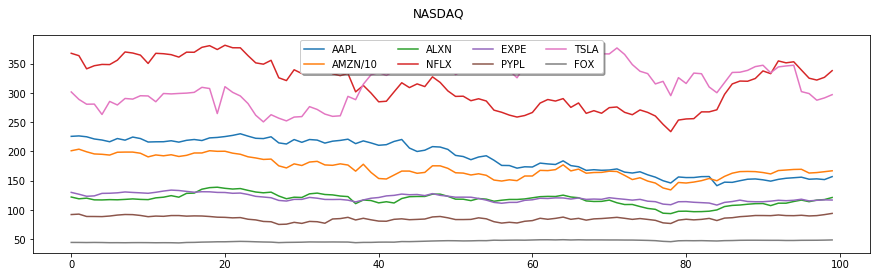

In [6]:
tickers=['AAPL','AMZN','ALXN','NFLX','EXPE','PYPL','TSLA','FOX']
# tickers=['AAPL']
for tick in tickers:
    y=companies[tick]
    if tick == 'AMZN':
        y=companies[tick]/10
        tick='AMZN/10'
    x=range(len(y))
    plt.figure(1, figsize = (15,4))
    plt.suptitle('NASDAQ')
    plt.plot(x,y,label=tick)
    leg = plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.),
          ncol=4, fancybox=True, shadow=True)

## 3. Simulation

Annualized standard deviation is required to use any simulation equation. As 100 days data is being used at this excercise, it's needed to annualize using $\sqrt{100}$ as follows:

\begin{equation}
\sigma=\sqrt{\displaystyle \sum_{i=1}^{N}(\overline{x}-x_i)^2}\cdot \sqrt{100}
\end{equation}

In [166]:
sigDict={}
for tick in tickers:
    sigDict[tick]=np.std(companies[tick])*np.sqrt(100)/np.mean(companies[tick])
sigDict

{'AAPL': 1.5015018112769674,
 'AMZN': 0.9904929940702457,
 'ALXN': 0.8216707670880825,
 'NFLX': 1.2575267456513683,
 'EXPE': 0.5177122436116248,
 'PYPL': 0.5037368322638529,
 'TSLA': 1.036998210799089,
 'FOX': 0.36717244462520293}

As well, divdends must be discounted from the stock prices, so first, dividends for the last year will be taken:

In [167]:
divsDict={}
for tick in tickers:
    divsDict[tick]=sum(dividends[tick])
divsDict

{'AAPL': 2.82,
 'AMZN': 0.0,
 'ALXN': 0.0,
 'NFLX': 0.0,
 'EXPE': 1.24,
 'PYPL': 0.0,
 'TSLA': 0.0,
 'FOX': 0.36}

In [168]:
# Seed
seed=123456789

# Number of scenarios
N=1000

# German 10 years bond yield
r=float(0.19/7)
ry=log(1+r)

# Period setting
d=52
T=1
dt=T/d

# Simulation dictionary {ticker: Nxd simulation values}
simDict={}

# Pay-off dictionary {ticker: {call:{ AVG: payoff mean, 
#                                     VAR: pay-off variance, 
#                                     ACC: pay-off precision}
#                             },
#                             {put:{ AVG: payoff mean, 
#                                    VAR: pay-off variance, 
#                                    ACC: pay-off precision}
#                             }
payDict={}
payoff12c=[]
payoff12p=[]

# The same for option values
valDict={}


for tick in tickers:
    sig=sigDict[tick]
    divs=log(1+divsDict[tick]/d)
    S0=companies[tick][99]
    tM=np.empty((0,d+1))
    
    for i in range(N):
        tm=[S0]    
        for i in range(d):
            if (i<1):
                x, y, u1, u2, antx, anty, seed = boxmuller(seed, mu=0, sigma=1)
                St=S0*(1+ry-divs)**dt+sig*S0*np.sqrt(dt)* y
                tm.append(St)
            else:
                x, y, u1, u2, antx, anty, seed = boxmuller(seed, mu=0, sigma=1)
                St=max(St*(1+ry-divs)**dt+sig*St*np.sqrt(dt)* y,0)
                tm.append(St)
    
        tm=np.array(tm)
        tM=np.vstack((tM,tm))
        payoff12c.append(max(np.mean(tm)-S0,0))
        payoff12p.append(max(S0-np.mean(tm),0))
        
    po12AVGc=np.mean(payoff12c)
    po12VARc=np.var(payoff12c, ddof=1)
    po12ACCc=t.ppf(1-0.05/2,len(tM))*np.sqrt(po12VARc/1000)

    val12AVGc=po12AVGc*np.exp(-rc*T)
    val12VARc=po12VARc*np.exp(-2*rc*T)
    val12ACCc=t.ppf(1-0.05/2,len(tM))*np.sqrt(val12VARc/1000)
    
    po12AVGp=np.mean(payoff12p)
    po12VARp=np.var(payoff12p, ddof=1)
    po12ACCp=t.ppf(1-0.05/2,len(tM))*np.sqrt(po12VARp/N)

    val12AVGp=po12AVGp*np.exp(-rc*T)
    val12VARp=po12VARp*np.exp(-2*rc*T)
    val12ACCp=t.ppf(1-0.05/2,len(tM))*np.sqrt(val12VARp/N)
    
    payDict[tick]={"call": {
                            "AVG": po12AVGc,
                            "VAR": po12VARc,
                            "ACC": po12ACCc
                            },
                   "put": {
                            "AVG": po12AVGp,
                            "VAR": po12VARp,
                            "ACC": po12ACCp
                           }
                  }
    
    valDict[tick]={"call": {
                            "AVG": val12AVGc,
                            "VAR": val12VARc,
                            "ACC": val12ACCc
                            },
                   "put": {
                            "AVG": val12AVGp,
                            "VAR": val12VARp,
                            "ACC": val12ACCp
                           }
                  }
        
        
    simDict[tick]=tM



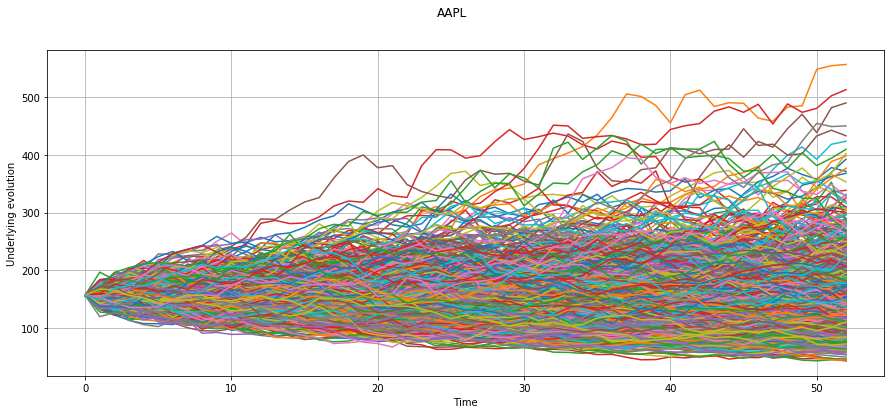

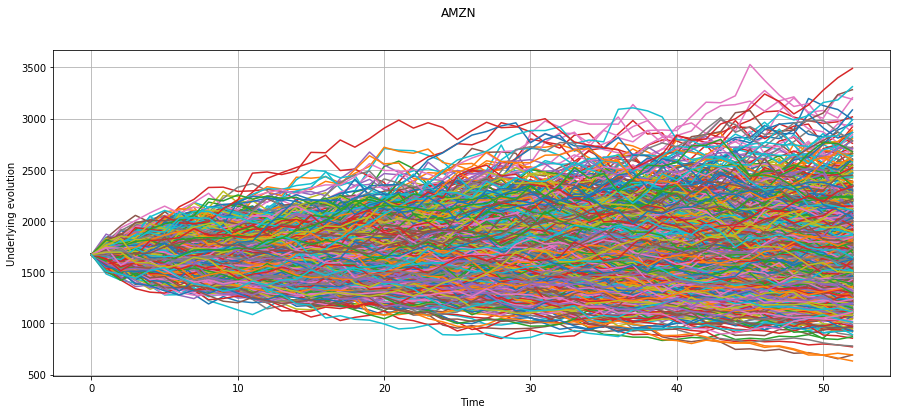

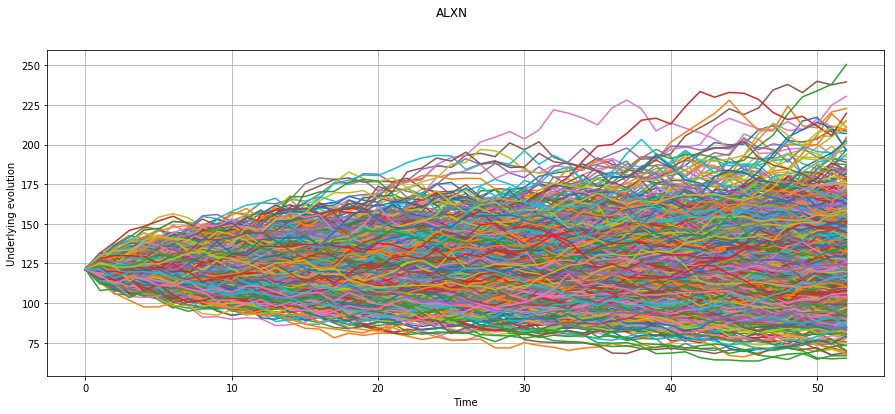

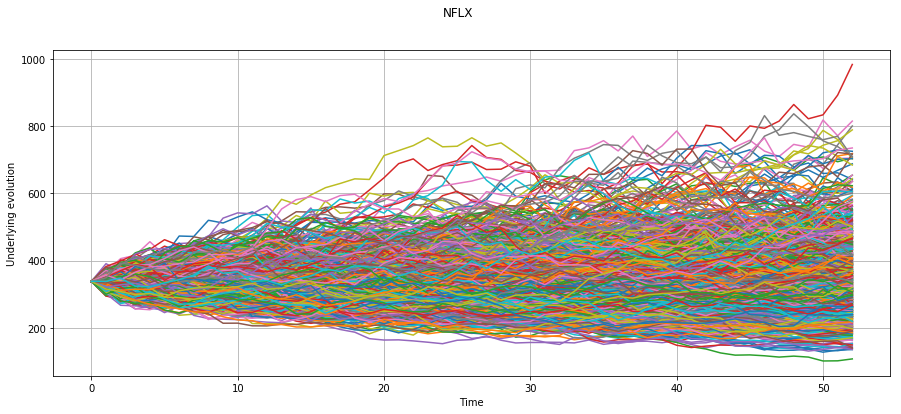

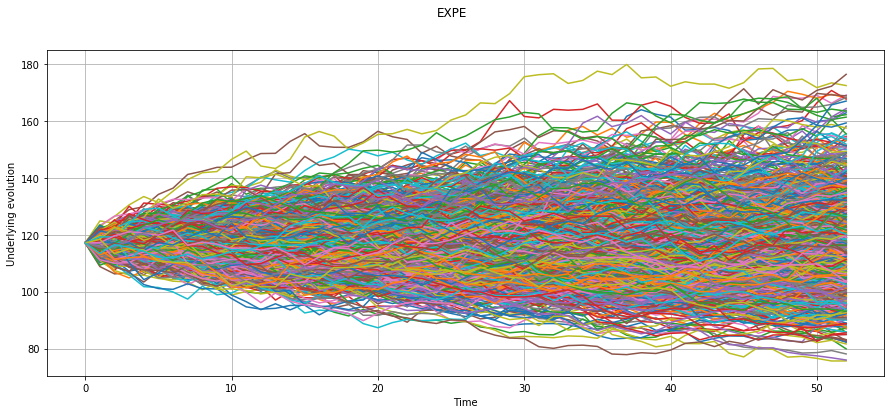

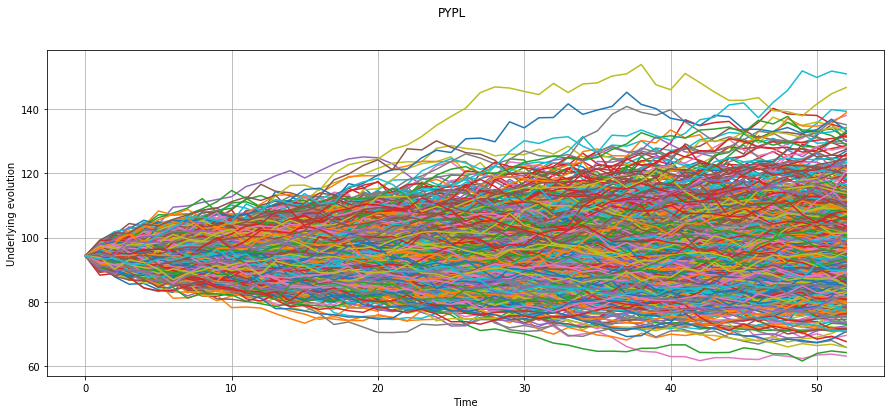

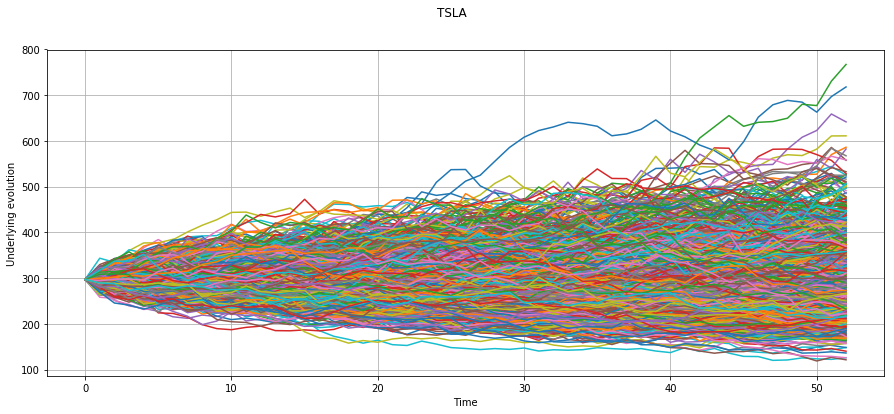

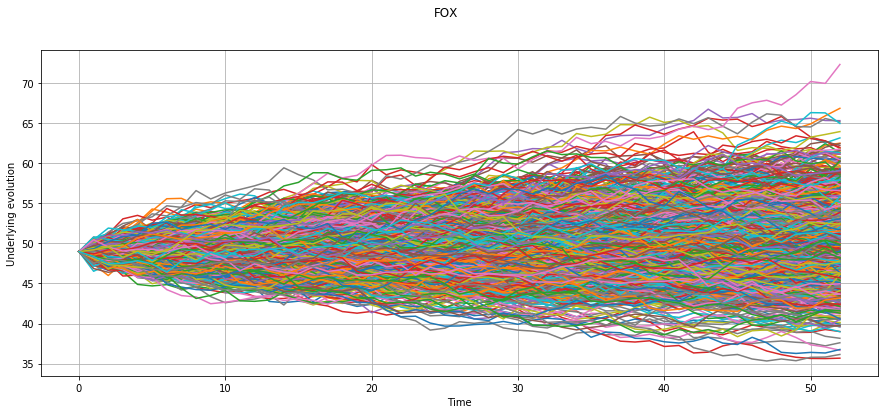

In [162]:
for tick in tickers:
    plt.figure(figsize=(15,6))
    ejex=range(d)
    plt.plot(np.matrix.transpose(simDict[tick]))
    plt.grid()
    plt.suptitle(tick)
    plt.xlabel('Time')
    plt.ylabel('Underlying evolution')


### 3.1 Observations

Observably, high volatility and companies that pay high dividends are likely to lose their value faster than those companies which show lower volatility and follow re-investment strategies. As well, high volatilty companies can reach high tops in some scenarios.

As an aditional information about the simulation, the simulated points are the weekly close price, so 52 prices are obtained for each simulation. It was done this way because a 12 points simulation is a very innacurate simulation for a one-year period.

## 4. Pay-Off

In [175]:
for tick in tickers:
    dfpo=pd.DataFrame(payDict[tick])
    dfval=pd.DataFrame(valDict[tick])
    print(color.BOLD+'Metrics for pay-off and value of', tick, 'options:')
    display(dfpo,dfval)
    print('\n')


Metrics for pay-off and value of AAPL options:


,call,put
ACC,12.332011,2.809924
AVG,56.484636,51.594292
VAR,39492.962607,2050.411708


,call,put
ACC,12.006131,2.735670
AVG,54.991996,50.230883
VAR,37433.291249,1943.476852




Metrics for pay-off and value of AMZN options:


,call,put
ACC,36.753132,18.790026
AVG,221.776921,201.434174
VAR,350784.674809,91686.763019


,call,put
ACC,35.781909,18.293488
AVG,215.916335,196.111157
VAR,332490.247149,86905.035156




Metrics for pay-off and value of ALXN options:


,call,put
ACC,30.602575,16.239905
AVG,156.117353,141.554355
VAR,243202.393796,68488.691561


,call,put
ACC,29.793884,15.810756
AVG,151.991860,137.813698
VAR,230518.690888,64916.809711




Metrics for pay-off and value of NFLX options:


,call,put
ACC,27.517127,14.389585
AVG,140.738573,129.338139
VAR,196633.748781,53771.041729


,call,put
ACC,26.789970,14.009332
AVG,137.019473,125.920302
VAR,186378.734378,50966.727562




Metrics for pay-off and value of EXPE options:


,call,put
ACC,24.821919,13.194834
AVG,115.418990,106.194719
VAR,160000.971160,45212.627529


,call,put
ACC,24.165986,12.846153
AVG,112.368975,103.388461
VAR,151656.461258,42854.659228




Metrics for pay-off and value of PYPL options:


,call,put
ACC,22.791135,12.251028
AVG,98.218583,90.248341
VAR,134891.254065,38975.974474


,call,put
ACC,22.188866,11.927288
AVG,95.623099,87.863476
VAR,127856.287982,36943.265531




Metrics for pay-off and value of TSLA options:


,call,put
ACC,21.404597,11.472600
AVG,94.604192,87.264295
VAR,118977.817002,34180.277779


,call,put
ACC,20.838968,11.169430
AVG,92.104221,84.958285
VAR,112772.782340,32397.678184




Metrics for pay-off and value of FOX options:


,call,put
ACC,20.107247,10.868248
AVG,83.385540,76.820228
VAR,104992.216887,30674.037924


,call,put
ACC,19.575901,10.581048
AVG,81.182027,74.790208
VAR,99516.571414,29074.298801


As visible in behind metrics, the variance is unnaceptable for every stock, so it would be impossible to take position based in this valuation